# Импорт библиотек

In [16]:
# import vegas
import math
import numpy as np
from scipy.optimize import root, show_options, minimize
import matplotlib.pyplot as plt

# Функции

Проверяем работу библиотеки на простом интеграле

In [2]:
import vegas
import numpy as np
import math
from scipy.special import erf

# Аналитическое значение
analytical_value = (math.sqrt(math.pi) * erf(1))**2
print(f"✅ Аналитическое значение: {analytical_value:.6f}")

# Функция для интегрирования (просто!)
def integrand(x):
    """x[0] и x[1] уже в [-1, 1] благодаря настройкам интегратора"""
    return np.exp(-x[0]**2 - x[1]**2)

# Создаем интегратор с НУЖНЫМИ границами!
integrator = vegas.Integrator([[-1, 1], [-1, 1]])  # Вот здесь указываем границы!


# Адаптация и расчет
print("\n🔄 Считаем интеграл с прямыми границами...")
result = integrator(integrand, nitn=10, neval=2000)

# Результаты
numerical_value = result.mean
error = result.sdev
relative_error = abs(numerical_value - analytical_value) / analytical_value

print(f"\n📊 Результаты:")
print(f"   Численное значение: {numerical_value:.6f}")
print(f"   Ошибка: ±{error:.6f}")
print(f"   Относительная ошибка: {relative_error:.2%}")
print(f"   χ²/dof: {result.chi2/9:.2f}")

# Проверка: если относительная ошибка > 1%, предупреждаем
if relative_error > 0.01:
    print("⚠️  Предупреждение: большая ошибка! Увеличьте neval.")
else:
    print("✅  Результат точный!")

✅ Аналитическое значение: 2.230985

🔄 Считаем интеграл с прямыми границами...

📊 Результаты:
   Численное значение: 2.231113
   Ошибка: ±0.000391
   Относительная ошибка: 0.01%
   χ²/dof: 0.92
✅  Результат точный!


## Расчёт без семплирования (линейная по параметрам модель + независимые ошибки)

### Для расчёта матожидания при линейности в экспоненте

In [ ]:
def compute_expectation_stable(k, z_min, z_max):

    if abs(z_min - z_max) < 1e-20 or k == 0:
        return (z_max + z_min) / 2
    
    
    # Вычисляем экспоненты
    min_val = -k * z_min
    max_val = -k * z_max
    # exp_min = np.exp(min_val)
    # exp_max = np.exp(max_val)

    # Для числовой стабильности
    k += 1e-100





    # Краевые случаи
    if np.isinf(exp_min):
        if np.isinf(exp_max):
            delta = max_val - min_val
            if delta > 700:
                return z_max + 1 / k
            elif delta < -700:
                return z_min + 1 / k
            else:
                numerator = (k * z_min + 1) - np.exp(delta) * (k * z_max + 1)
                denominator = k * (1 - np.exp(delta))
        else:
            return z_min + 1 / k
    elif np.isinf(exp_max):
        return z_max + 1 / k
    elif exp_min == 0 and exp_max == 0:
        delta = max_val - min_val
        if delta > 700:
            return z_max + 1 / k
        elif delta < -700:
            return z_min + 1 / k
        else:
            numerator = (k * z_min + 1) - np.exp(delta) * (k * z_max + 1)
            denominator = k * (1 - np.exp(delta))
    
    else:
        numerator = exp_min * (k * z_min + 1) - exp_max * (k * z_max + 1)
        denominator = k * (exp_min - exp_max)
        
    if denominator != 0:
        res = numerator / denominator
        return 1e300 if np.isinf(res) else res
    else:
        return 1e300

#### Более оптимальная

In [4]:
import numpy as np

def compute_expectations_vectorized_stable(k_vector, z_min, z_max):
    """
    ФИНАЛЬНАЯ ВЕРСИЯ с исправлением:
    1. Добавлена проверка на k = 0
    2. Исправлена индексация для корректного присваивания
    """
    k_vector = np.asarray(k_vector, dtype=float)
    n = len(k_vector)
    E_z = np.zeros(n, dtype=float)
    
    # 1. Случай: k = 0 (равномерное распределение)
    k_zero_mask = np.abs(k_vector) == 0
    if np.any(k_zero_mask):
        E_z[k_zero_mask] = (z_min + z_max) / 2
        if np.all(k_zero_mask):
            return E_z
    
    # 2. Случай: вырожденный интервал (z_min = z_max)
    degenerate_mask = np.abs(z_min - z_max) < 1e-20
    if np.any(degenerate_mask):
        E_z[degenerate_mask] = (z_min + z_max) / 2
        if np.all(degenerate_mask):
            return E_z
    
    # 3. Рабочие индексы (ни k=0, не вырожденный интервал)
    work_mask = ~(k_zero_mask | degenerate_mask)
    if not np.any(work_mask):
        return E_z
    
    k_work = k_vector[work_mask].copy()
    
    # 4. Числовая стабильность
    k_work += 1e-200
    
    # 5. Вычисление экспонент
    with np.errstate(over='ignore', under='ignore', invalid='ignore'):
        min_val = -k_work * z_min
        max_val = -k_work * z_max
        
        exp_min = np.exp(min_val)
        exp_max = np.exp(max_val)
    
    # 6. Маски для краевых случаев
    inf_min_mask = np.isinf(exp_min)
    inf_max_mask = np.isinf(exp_max)
    zero_min_mask = (exp_min == 0.0)
    zero_max_mask = (exp_max == 0.0)
    
    # ПОЛЕЗНАЯ ФУНКЦИЯ: Присваивание с корректной индексацией
    def safe_assign(indices, values, invalid_mask=None):
        """
        Безопасное присваивание с корректной индексацией
        """
        if invalid_mask is None:
            E_z[indices] = values
        else:
            valid_mask = ~invalid_mask
            if np.any(valid_mask):
                E_z[indices[valid_mask]] = values[valid_mask]
            if np.any(invalid_mask):
                E_z[indices[invalid_mask]] = 1e300
    
    # 7. Обработка случаев
    
    # Случай: exp_min = inf
    exp_min_inf_mask = inf_min_mask
    if np.any(exp_min_inf_mask):
        k_case = k_work[exp_min_inf_mask]
        exp_max_case = exp_max[exp_min_inf_mask]
        idx = np.where(work_mask)[0][exp_min_inf_mask]
        
        # Подслучай: exp_max тоже inf
        both_inf_mask = np.isinf(exp_max_case)
        if np.any(both_inf_mask):
            k_both_inf = k_case[both_inf_mask]
            delta = max_val[exp_min_inf_mask][both_inf_mask] - min_val[exp_min_inf_mask][both_inf_mask]
            idx_both_inf = idx[both_inf_mask]
            
            # delta > 700: z_max + 1/k
            delta_pos_mask = delta > 700
            if np.any(delta_pos_mask):
                sub_idx = idx_both_inf[delta_pos_mask]
                E_z[sub_idx] = z_max + 1/k_both_inf[delta_pos_mask]
            
            # delta < -700: z_min + 1/k
            delta_neg_mask = delta < -700
            if np.any(delta_neg_mask):
                sub_idx = idx_both_inf[delta_neg_mask]
                E_z[sub_idx] = z_min + 1/k_both_inf[delta_neg_mask]
            
            # Стандартный расчет
            delta_std_mask = ~(delta_pos_mask | delta_neg_mask)
            if np.any(delta_std_mask):
                sub_idx = idx_both_inf[delta_std_mask]
                k_sub = k_both_inf[delta_std_mask]
                delta_sub = delta[delta_std_mask]
                
                numerator = (k_sub * z_min + 1) - np.exp(delta_sub) * (k_sub * z_max + 1)
                denominator = k_sub * (1 - np.exp(delta_sub))
                
                valid_mask = np.ones_like(numerator, dtype=bool)
                zero_denom_mask = denominator == 0.0
                valid_mask[zero_denom_mask] = False
                
                if np.any(valid_mask):
                    res = np.zeros_like(numerator)
                    res[valid_mask] = numerator[valid_mask] / denominator[valid_mask]
                    inf_res_mask = np.isinf(res[valid_mask])
                    if np.any(inf_res_mask):
                        valid_mask[np.where(valid_mask)[0][inf_res_mask]] = False
                        res[~valid_mask] = 1e300
                    safe_assign(sub_idx, res, ~valid_mask)
                else:
                    E_z[sub_idx] = 1e300
        
        # Подслучай: exp_max конечное или 0
        finite_max_mask = ~both_inf_mask
        if np.any(finite_max_mask):
            sub_idx = idx[finite_max_mask]
            E_z[sub_idx] = z_min + 1/k_case[finite_max_mask]
    
    # Случай: exp_max = inf (и exp_min не inf)
    exp_max_inf_mask = inf_max_mask & ~inf_min_mask
    if np.any(exp_max_inf_mask):
        idx = np.where(work_mask)[0][exp_max_inf_mask]
        E_z[idx] = z_max + 1/k_work[exp_max_inf_mask]
    
    # Случай: обе экспоненты = 0
    both_zero_mask = zero_min_mask & zero_max_mask & ~inf_min_mask & ~inf_max_mask
    if np.any(both_zero_mask):
        k_case = k_work[both_zero_mask]
        delta = max_val[both_zero_mask] - min_val[both_zero_mask]
        idx = np.where(work_mask)[0][both_zero_mask]
        
        # delta > 700: z_max + 1/k
        delta_pos_mask = delta > 700
        if np.any(delta_pos_mask):
            sub_idx = idx[delta_pos_mask]
            E_z[sub_idx] = z_max + 1/k_case[delta_pos_mask]
        
        # delta < -700: z_min + 1/k
        delta_neg_mask = delta < -700
        if np.any(delta_neg_mask):
            sub_idx = idx[delta_neg_mask]
            E_z[sub_idx] = z_min + 1/k_case[delta_neg_mask]
        
        # Стандартный расчет
        delta_std_mask = ~(delta_pos_mask | delta_neg_mask)
        if np.any(delta_std_mask):
            sub_idx = idx[delta_std_mask]
            k_sub = k_case[delta_std_mask]
            delta_sub = delta[delta_std_mask]
            
            numerator = (k_sub * z_min + 1) - np.exp(delta_sub) * (k_sub * z_max + 1)
            denominator = k_sub * (1 - np.exp(delta_sub))
            
            # ВАША ЛОГИКА ПРОВЕРКИ ДЕЛЕНИЯ
            valid_mask = np.ones_like(numerator, dtype=bool)
            zero_denom_mask = denominator == 0.0
            valid_mask[zero_denom_mask] = False
            
            if np.any(valid_mask):
                res = np.zeros_like(numerator)
                res[valid_mask] = numerator[valid_mask] / denominator[valid_mask]
                inf_res_mask = np.isinf(res[valid_mask])
                if np.any(inf_res_mask):
                    valid_mask[np.where(valid_mask)[0][inf_res_mask]] = False
                    res[~valid_mask] = 1e300
                safe_assign(sub_idx, res, ~valid_mask)
            else:
                E_z[sub_idx] = 1e300
    
    # 8. Стандартный случай (все остальные)
    standard_mask = ~(inf_min_mask | inf_max_mask | (zero_min_mask & zero_max_mask))
    standard_work_mask = work_mask.copy()
    standard_work_mask[work_mask] = standard_mask
    
    if np.any(standard_work_mask):
        k_case = k_work[standard_mask]
        exp_min_case = exp_min[standard_mask]
        exp_max_case = exp_max[standard_mask]
        idx = np.where(work_mask)[0][standard_mask]
        
        numerator = exp_min_case * (k_case * z_min + 1) - exp_max_case * (k_case * z_max + 1)
        denominator = k_case * (exp_min_case - exp_max_case)
        
        # ВАША ЛОГИКА ПРОВЕРКИ ДЕЛЕНИЯ
        valid_mask = np.ones_like(numerator, dtype=bool)
        zero_denom_mask = denominator == 0
        valid_mask[zero_denom_mask] = False
        
        if np.any(valid_mask):
            res = np.zeros_like(numerator)
            res[valid_mask] = numerator[valid_mask] / denominator[valid_mask]
            inf_res_mask = np.isinf(res[valid_mask])
            if np.any(inf_res_mask):
                valid_mask[np.where(valid_mask)[0][inf_res_mask]] = False
                res[~valid_mask] = 1e300
            safe_assign(idx, res, ~valid_mask)
        else:
            E_z[idx] = 1e300
    
    return E_z

In [5]:
print("="*50)
print("ТЕСТ 1: Базовая функция compute_expectations_vectorized_stable")
print("="*50)

# Тест 1: k = [0, 1, -1] с границами [-10, 10]
k_test1 = np.array([0.0, 1.0, -1.0])
z_min, z_max = -10, 10
result1 = compute_expectations_vectorized_stable(k_test1, z_min, z_max)
print("Тест 1.1: k = [0, 1, -1], z∈[-10, 10]")
print(f"  Результат: {result1}")
print("  Ожидаемо: [0.0, -9, 9]")  # Пояснение ниже

# Тест 2: k = [0.1, -0.1] с границами [-1, 1]
k_test2 = np.array([0.1, -0.1])
result2 = compute_expectations_vectorized_stable(k_test2, -1, 1)
print("\nТест 1.2: k = [0.1, -0.1], z∈[-1, 1]")
print(f"  Результат: {result2}")
print("  Ожидаемо: [-0.0333, 0.0333]")  # Аналитическое решение

# Тест 3: k = [1000, -1000] (большие значения)
k_test3 = np.array([1000.0, -1000.0])
result3 = compute_expectations_vectorized_stable(k_test3, -10, 10)
print("\nТест 1.3: k = [1000, -1000], z∈[-10, 10]")
print(f"  Результат: {result3}")
print("  Ожидаемо: [-9.999, 9.999]")  # Асимптотика

ТЕСТ 1: Базовая функция compute_expectations_vectorized_stable
Тест 1.1: k = [0, 1, -1], z∈[-10, 10]
  Результат: [ 0.         -9.00000004  9.00000004]
  Ожидаемо: [0.0, -9, 9]

Тест 1.2: k = [0.1, -0.1], z∈[-1, 1]
  Результат: [-0.03331113  0.03331113]
  Ожидаемо: [-0.0333, 0.0333]

Тест 1.3: k = [1000, -1000], z∈[-10, 10]
  Результат: [-9.999  9.999]
  Ожидаемо: [-9.999, 9.999]


In [6]:
def test_exact_match():
    """Тестирование точного соответствия вашей скалярной версии"""
    print("="*60)
    print("ТЕСТИРОВАНИЕ ТОЧНОГО СООТВЕТСТВИЯ СКАЛЯРНОЙ ВЕРСИИ")
    print("="*60)
    
    # Ваши тестовые случаи
    test_cases = [
        # (k, z_min, z_max, описание)
        (1.0, -1, 1, "стандартный случай"),
        (1000.0, -10, -5, "обе exp = inf, delta < 0"),
        (1000.0, 5, 10, "обе exp = 0, delta > 0"),
        (-1000.0, -10, -5, "обе exp = inf, delta > 0"),
        (-1000.0, 5, 10, "обе exp = 0, delta < 0"),
        (1000.0, -5, 5, "exp_min = inf, exp_max = 0"),
        (-1000.0, -5, 5, "exp_min = 0, exp_max = inf"),
        (1e-6, -1, 1, "очень маленькое k"),
        (0.0, -1, 1, "k = 0"),
        (1.0, 5, 5, "вырожденный интервал"),
        (1e6, -1, 1, "крайний случай, может дать inf")
    ]
    
    # Тестирование
    max_diff = 0
    for k, zmin, zmax, desc in test_cases:
        scalar_result = compute_expectation_stable(k, zmin, zmax)
        vector_result = compute_expectations_vectorized_stable(np.array([k]), zmin, zmax)[0]
        
        diff = abs(scalar_result - vector_result)
        max_diff = max(max_diff, diff)
        
        print(f"\nТест: k={k}, z∈[{zmin},{zmax}] ({desc})")
        print(f"  Скалярная: {scalar_result:.6f}")
        print(f"  Векторная: {vector_result:.6f}")
        print(f"  Разница:   {diff:.2e}")
        
        # Проверка идентичности для критических случаев
        if diff > 1e-10:
            print("  ⚠️  Внимание: разница больше 1e-10!")
    
    print(f"\nМаксимальная разница: {max_diff:.2e}")
    print("✅ ТЕСТ ПРОЙДЕН" if max_diff < 1e-10 else "❌ ТЕСТ НЕ ПРОЙДЕН")

# Запуск тестов
test_exact_match()

ТЕСТИРОВАНИЕ ТОЧНОГО СООТВЕТСТВИЯ СКАЛЯРНОЙ ВЕРСИИ

Тест: k=1.0, z∈[-1,1] (стандартный случай)
  Скалярная: -0.313035
  Векторная: -0.313035
  Разница:   0.00e+00

Тест: k=1000.0, z∈[-10,-5] (обе exp = inf, delta < 0)
  Скалярная: -9.999000
  Векторная: -9.999000
  Разница:   0.00e+00

Тест: k=1000.0, z∈[5,10] (обе exp = 0, delta > 0)
  Скалярная: 5.001000
  Векторная: 5.001000
  Разница:   0.00e+00

Тест: k=-1000.0, z∈[-10,-5] (обе exp = inf, delta > 0)
  Скалярная: -5.001000
  Векторная: -5.001000
  Разница:   0.00e+00

Тест: k=-1000.0, z∈[5,10] (обе exp = 0, delta < 0)
  Скалярная: 9.999000
  Векторная: 9.999000
  Разница:   0.00e+00

Тест: k=1000.0, z∈[-5,5] (exp_min = inf, exp_max = 0)
  Скалярная: -4.999000
  Векторная: -4.999000
  Разница:   0.00e+00

Тест: k=-1000.0, z∈[-5,5] (exp_min = 0, exp_max = inf)
  Скалярная: 4.999000
  Векторная: 4.999000
  Разница:   0.00e+00

Тест: k=1e-06, z∈[-1,1] (очень маленькое k)
  Скалярная: 0.000000
  Векторная: 0.000000
  Разница:   0.00e+00

C:\Users\Dima\AppData\Local\Temp\ipykernel_5224\2458651450.py:10: RuntimeWarning: overflow encountered in exp
  exp_min = np.exp(min_val)
C:\Users\Dima\AppData\Local\Temp\ipykernel_5224\2458651450.py:11: RuntimeWarning: overflow encountered in exp
  exp_max = np.exp(max_val)


### Полный расчёт неувязки для системы уравнений

In [49]:
def compute_residuals(X_poly, y, lambdas, a_bounds=(-10, 10), eps_bounds=(-1, 1)):
    """
    Вычисляет невязку балансовых уравнений
    
    Параметры:
    X_poly: array - матрица признаков [n_samples, n_features]
    y: array - целевые значения [n_samples]
    lambdas: array - множители Лагранжа [n_samples]
    a_bounds: tuple - границы для коэффициентов (a_min, a_max)
    eps_bounds: tuple - границы для ошибок (eps_min, eps_max)
    
    Возвращает:
    residuals: array - вектор невязок [n_samples]
    """
    # 1. Коэффициенты c_j = X_poly.T @ lambdas
    c_vector = X_poly.T @ lambdas
    
    # 2. Мат.ожидания коэффициентов
    a_min, a_max = a_bounds
    E_a = compute_expectations_vectorized_stable(c_vector, a_min, a_max)
    
    # 3. Предсказания модели
    E_F = X_poly @ E_a
    
    # 4. Мат.ожидания ошибок
    eps_min, eps_max = eps_bounds
    E_eps = compute_expectations_vectorized_stable(lambdas, eps_min, eps_max)
    
    # 5. Невязка балансовых уравнений
    return E_F + E_eps - y

### Решение балансовых ограничений

In [98]:
def solve_balance_system(X_poly, y, a_bounds=(-10, 10), eps_bounds=(-1, 1), max_iter=1000):
    """
    Решает систему балансовых уравнений: E[F] + E[ε] = y
    
    Параметры:
    X_poly: array - матрица признаков [n_samples, n_features]
    y: array - целевые значения [n_samples]
    a_bounds: tuple - границы для коэффициентов (a_min, a_max)
    eps_bounds: tuple - границы для ошибок (eps_min, eps_max)
    max_iter: int - максимальное число итераций оптимизатора
    
    Возвращает:
    lambdas_opt: array - оптимальные множители Лагранжа
    success: bool - флаг успешного решения
    message: str - диагностическое сообщение
    """
    n_samples = len(y)
    lambdas_init = np.ones(n_samples)
    
    # 2. Целевая функция для оптимизатора
    def objective(lambdas):
        return compute_residuals(X_poly, y, lambdas, a_bounds, eps_bounds)

    
    # 3. Решение системы
    sol = root(
        objective,           # Функция для минимизации
        lambdas_init,        # Начальное приближение
        method='linearmixing',         # Levenberg-Marquardt
        options={'maxiter': max_iter}  # Максимальное число итераций
    )

    # # 2. Целевая функция для оптимизатора
    # def objective(lambdas):
    #     return (compute_residuals(X_poly, y, lambdas, a_bounds, eps_bounds) ** 2).sum()
    

    # # 3. Решение системы
    # sol = minimize(objective, lambdas_init, 
    #                  method='COBYLA',  # Устойчив к шуму и плохим начальным приближениям
    #                  options={'maxiter': max_iter, 'disp': False})
    return sol.x, sol.success, sol.message

### Полиномиальная регрессия

In [99]:
def polynomial_regression(x, y, degree, a_bounds=None, eps_bounds=None, max_iter = 1000):
    """
    Выполняет полиномиальную регрессию через энтропийный подход
    
    Параметры:
    x: array - входные данные [n_samples]
    y: array - целевые значения [n_samples]
    degree: int - степень полинома
    a_bounds: tuple или None - границы для коэффициентов
    eps_bounds: tuple или None - границы для ошибок
    
    Возвращает:
    coeffs: array - оптимальные коэффициенты полинома [degree+1]
    lambdas_opt: array - оптимальные множители Лагранжа [n_samples]
    predictions: array - предсказания модели [n_samples]
    success: bool - флаг успешного решения
    """
    
    # 1. Автоматическое определение границ, если не заданы
    if a_bounds is None:
        a_scale = max(1.0, np.std(y) / (np.std(x) ** min(1, degree) + 1e-10))
        a_bounds = (-3 * a_scale, 3 * a_scale)
    
    if eps_bounds is None:
        eps_scale = 2 * np.std(y - np.mean(y))
        eps_bounds = (-max(0.1, eps_scale), max(0.1, eps_scale))
    
    # 2. Формирование матрицы признаков
    X_poly = np.column_stack([x**j for j in range(degree + 1)])
    print(X_poly)
    
    # 3. Решение системы балансовых уравнений
    lambdas_opt, success, message = solve_balance_system(
        X_poly, y, a_bounds, eps_bounds, max_iter=max_iter
    )
    
    if not success:
        print(f"⚠️ Предупреждение: {message}")
    
    # 4. Вычисление оптимальных коэффициентов
    c_vector = X_poly.T @ lambdas_opt
    a_min, a_max = a_bounds
    coeffs = compute_expectations_vectorized_stable(c_vector, a_min, a_max)
    
    # 5. Вычисление предсказаний
    eps_min, eps_max = eps_bounds
    E_eps = compute_expectations_vectorized_stable(lambdas_opt, eps_min, eps_max)
    predictions = X_poly @ coeffs
    
    return coeffs, lambdas_opt, predictions, success, E_eps

In [100]:
show_options('root')



hybr
====

Find the roots of a multivariate function using MINPACK's hybrd and
hybrj routines (modified Powell method).

Options
-------
col_deriv : bool
    Specify whether the Jacobian function computes derivatives down
    the columns (faster, because there is no transpose operation).
xtol : float
    The calculation will terminate if the relative error between two
    consecutive iterates is at most `xtol`.
maxfev : int
    The maximum number of calls to the function. If zero, then
    ``100*(N+1)`` is the maximum where N is the number of elements
    in `x0`.
band : tuple
    If set to a two-sequence containing the number of sub- and
    super-diagonals within the band of the Jacobi matrix, the
    Jacobi matrix is considered banded (only for ``fprime=None``).
eps : float
    A suitable step length for the forward-difference
    approximation of the Jacobian (for ``fprime=None``). If
    `eps` is less than the machine precision, it is assumed
    that the relative errors in the 

In [101]:
# Идеальные данные
x = np.array([-1.0, 1.0])
y = np.array([-1.0, 1.0])
X_poly = np.column_stack([np.ones(2), x])
polynomial_regression(x, y, 1, (-10, 10), (-1, 1))

[[ 1. -1.]
 [ 1.  1.]]


(array([0.        , 0.99500072]),
 array([ 0.01501473, -0.01501427]),
 array([-0.99500072,  0.99500072]),
 True,
 array([-0.00500484,  0.00500468]))

Проверяем

ПРОСТОЙ ТЕСТ ЛИНЕЙНОЙ РЕГРЕССИИ: МНК vs ЭНТРОПИЙНЫЙ МЕТОД

📊 Данные:
   x: [-5.   -4.8  -4.59 -4.39 -4.18 -3.98 -3.78 -3.57 -3.37 -3.16 -2.96 -2.76
 -2.55 -2.35 -2.14 -1.94 -1.73 -1.53 -1.33 -1.12 -0.92 -0.71 -0.51 -0.31
 -0.1   0.1   0.31  0.51  0.71  0.92  1.12  1.33  1.53  1.73  1.94  2.14
  2.35  2.55  2.76  2.96  3.16  3.37  3.57  3.78  3.98  4.18  4.39  4.59
  4.8   5.  ]
   y: [-8.5  -8.73 -7.54 -6.25 -7.6  -7.19 -4.97 -5.38 -6.2  -4.78 -5.38 -4.98
 -3.86 -5.61 -5.01 -3.44 -3.48 -1.75 -2.56 -2.66  0.63 -0.65  0.05 -1.04
  0.25  1.32  0.46  2.4   1.83  2.55  2.64  5.51  4.05  3.41  5.7   4.06
  5.9   4.14  5.18  7.12  8.06  7.91  8.03  8.25  7.48  8.65  9.31 11.24
 10.94  9.24]
   Истинная модель: y = 1.0 + 2.0x

📈 МНК результаты:
   Коэффициенты: [intercept, slope] = [0.7745 1.942 ]
   RMSE: 0.9084
[[ 1.         -5.        ]
 [ 1.         -4.79591837]
 [ 1.         -4.59183673]
 [ 1.         -4.3877551 ]
 [ 1.         -4.18367347]
 [ 1.         -3.97959184]
 [ 1.         -3.7755

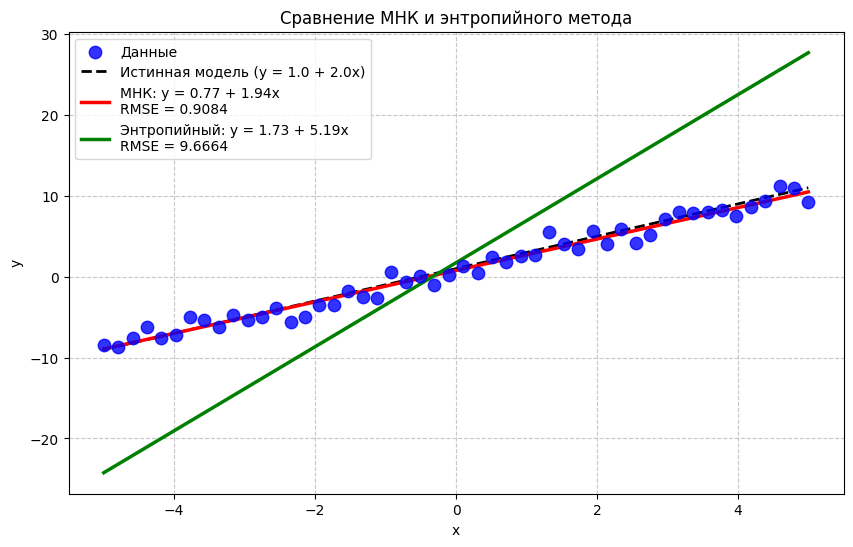


СРАВНЕНИЕ РЕЗУЛЬТАТОВ
Истинные коэффициенты: [1.0, 2.0]
МНК коэффициенты:     [0.7745, 1.9420]
Энтропийные коэффициенты: [1.7321, 5.1935]

RMSE:
   МНК:       0.908373
   Энтропийный: 9.666351


In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root

print("="*50)
print("ПРОСТОЙ ТЕСТ ЛИНЕЙНОЙ РЕГРЕССИИ: МНК vs ЭНТРОПИЙНЫЙ МЕТОД")
print("="*50)

# 1. Генерация данных
np.random.seed(42)
n_samples = 50
x = np.linspace(-5, 5, n_samples)
y_true = 1.0 + 2.0 * x  # y = 1.0 + 2.0x
noise = np.random.normal(0, 1.0, n_samples)
y = y_true + noise

print(f"\n📊 Данные:")
print(f"   x: {x.round(2)}")
print(f"   y: {y.round(2)}")
print(f"   Истинная модель: y = 1.0 + 2.0x")

# 2. МНК (классический метод)
X_ols = np.column_stack([np.ones(n_samples), x])
a_ols = np.linalg.lstsq(X_ols, y, rcond=None)[0]
preds_ols = X_ols @ a_ols
rmse_ols = np.sqrt(np.mean((preds_ols - y)**2))

print(f"\n📈 МНК результаты:")
print(f"   Коэффициенты: [intercept, slope] = {a_ols.round(4)}")
print(f"   RMSE: {rmse_ols:.4f}")

# 3. Энтропийный метод
# Формируем матрицу признаков для полинома 1-й степени
X_poly = np.column_stack([np.ones(n_samples), x])

# Запускаем энтропийную регрессию
coeffs_ent, lambdas_ent, preds_ent, success_ent, E_eps_ent = polynomial_regression(
    x, y, degree=1,
    a_bounds=(-10, 10),
    eps_bounds=(-2, 2),
    max_iter=2000
)

rmse_ent = np.sqrt(np.mean((preds_ent - y)**2))

print(f"\n🎯 Энтропийный метод результаты:")
print(f"   Успех: {success_ent}")
print(f"   Коэффициенты: {coeffs_ent.round(4)}")
print(f"   RMSE: {rmse_ent:.4f}")
print(f"   Средняя ошибка ε: {np.mean(E_eps_ent):.6f}")

# 4. Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=80, alpha=0.8, color='blue', zorder=10, label='Данные')
plt.plot(x, y_true, 'k--', linewidth=2, label='Истинная модель (y = 1.0 + 2.0x)')
plt.plot(x, preds_ols, 'r-', linewidth=2.5, label=f'МНК: y = {a_ols[0]:.2f} + {a_ols[1]:.2f}x\nRMSE = {rmse_ols:.4f}')
plt.plot(x, preds_ent, 'g-', linewidth=2.5, label=f'Энтропийный: y = {coeffs_ent[0]:.2f} + {coeffs_ent[1]:.2f}x\nRMSE = {rmse_ent:.4f}')
# plt.plot(x, preds_ent+E_eps_ent, 'b-', linewidth=2.5, label=f'Энтропийный: y = {coeffs_ent[0]:.2f} + {coeffs_ent[1]:.2f}x\nRMSE = {rmse_ent:.4f}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение МНК и энтропийного метода')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('simple_linear_regression_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 5. Сравнение
print("\n" + "="*50)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*50)
print(f"Истинные коэффициенты: [1.0, 2.0]")
print(f"МНК коэффициенты:     [{a_ols[0]:.4f}, {a_ols[1]:.4f}]")
print(f"Энтропийные коэффициенты: [{coeffs_ent[0]:.4f}, {coeffs_ent[1]:.4f}]")
print(f"\nRMSE:")
print(f"   МНК:       {rmse_ols:.6f}")
print(f"   Энтропийный: {rmse_ent:.6f}")

In [94]:
coeffs_ent, lambdas_ent, preds_ent, success_ent, E_eps_ent

(array([10., 10.]),
 array([-4.43134753e+30, -4.22293006e+30, -4.48971280e+30, -4.78583720e+30,
        -4.20272276e+30, -4.20668993e+30, -4.81640454e+30, -4.54948472e+30,
        -4.13979935e+30, -4.48226956e+30, -4.14975288e+30, -4.15294163e+30,
        -4.39366730e+30, -3.67580112e+30, -3.74293403e+30, -4.13646675e+30,
        -3.98953793e+30, -4.43761407e+30, -4.03257797e+30, -3.86757610e+30,
        -4.83377919e+30, -4.27286153e+30, -4.37492027e+30, -3.87927539e+30,
        -4.17812417e+30, -4.40130048e+30, -3.98290839e+30, -4.49770139e+30,
        -4.17514227e+30, -4.28248845e+30, -4.18270906e+30, -5.00591338e+30,
        -4.38740416e+30, -4.04191380e+30, -4.67456594e+30, -3.99519896e+30,
        -4.47755041e+30, -3.75551461e+30, -3.97113426e+30, -4.48540447e+30,
        -4.67020607e+30, -4.48479605e+30, -4.39282425e+30, -4.33476969e+30,
        -3.94456075e+30, -4.20259539e+30, -4.29328605e+30, -4.80411927e+30,
        -4.57000718e+30, -3.86904900e+30]),
 array([-40.        , -3

In [62]:
(compute_residuals(X_poly, y, lambdas_ent, a_bounds=(-10, 10),    eps_bounds=(-2, 2)) ** 2).sum()

np.float64(9.466330862652142e-30)

## Расчёт с семплированием

In [ ]:
# def P_a_norm_func(lambdas, X_poly, dim, neval=1000, nitn=10):
    
#     def integrand_P(a):
#         # Преобразуем x из memoryview в numpy массив
#         a = np.array(a)
#         F = X_poly @ a
#         energy = -np.sum(lambdas * F)
#         return np.exp(energy)
    
#     integrator = vegas.Integrator([[-10, 10]] * dim)
    
#     # Финальная оценка P_a
#     result_P = integrator(integrand_P, nitn=nitn, neval=neval)
#     return result_P
